# diag_dissip_fromMean
diagnose dissipation from mean 2D and 3D dissip netCDF files (data from ROMS)

N.B.: these files contain cell-volume-integrated dissipation

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
#from mpl_toolkits.axes_grid1 import ImageGrid
plt.rcParams['font.family'] = "serif"

import numpy as np
from netCDF4 import Dataset
import sys, time, os
for pap in ["/home/lahaye/"+pa for pa in ["Coding/Python_ROMS_Modules/lahaye"]]:
    if pap not in sys.path: sys.path.append(pap)
import comp_zlevs as zlev
import gsw

KRYPTON = "/data0/project/vortex/lahaye/"
RUCHBA = "/net/ruchba/local/tmp/2/lahaye/"

In [2]:
# useful functions
def symlog(x, a): 
    return np.where(np.log10(abs(x))>=a, np.log10(abs(x))-a, np.nan)*np.sign(x)

In [9]:
# set parameters

simul = "luckyto"

j1, j2, i1, i2 = 0, 2002, 0, 2002 #822, 1118, 878, 1174 #868, 1068, 927, 1127   # subdomain coordinates
nsx = 2  # horizontal subsampling step

dosavefig = False
picdir = "pictures/MomarPrep"

if simul == "luckyk1":
    its = 132, 176
elif simul =="luckyto":
    its = 900, 1080
    itm = 720, 1080
else:
    raise ValueError('simul {} unknown'.format(simul))
path_mean = KRYPTON + "{0}_his.mean.{1:05d}-{2:05d}.nc".format(simul,*itm)    
path_di2D = RUCHBA+"data_from_Irene/{0}/{1}_diags_ek_avg.{2:05d}-{3:05d}.nc"\
                        .format(simul.upper(),simul,its[0],its[1])
path_di3D = path_di2D.replace('diags_ek','diags_pv')
path_grid = KRYPTON+"lucky_corgrd.nc"


In [10]:
# load grid and topo 
nc = Dataset(path_grid, "r")
ncvar = nc.variables
lon = ncvar['lon_rho'][j1:j2:nsx,:][:,i1:i2:nsx]
lat = ncvar['lat_rho'][j1:j2:nsx,:][:,i1:i2:nsx]
topo = ncvar['h'][j1:j2:nsx,:][:,i1:i2:nsx]
pm = ncvar['pm'][j1:j2:nsx,:][:,i1:i2:nsx]
pn = ncvar['pn'][j1:j2:nsx,:][:,i1:i2:nsx]
nc.close()
print("loaded grid & topo data")

loaded grid & topo data


In [11]:
# load 2D data
nc = Dataset(path_di2D, "r")
ncvar = nc.variables
vmix = ncvar['ek_vmix_mean'][j1:j2:nsx,:][:,i1:i2:nsx]
drag = ncvar['ek_Drag_mean'][j1:j2:nsx,:][:,i1:i2:nsx]
hdif = ncvar['ek_hdiff_mean'][j1:j2:nsx,:][:,i1:i2:nsx]
hadv = ncvar['ek_hadv_mean'][j1:j2:nsx,:][:,i1:i2:nsx]
prgd = ncvar['ek_Prsgrd_mean'][j1:j2:nsx,:][:,i1:i2:nsx]
rate = ncvar['ek_rate_mean'][j1:j2:nsx,:][:,i1:i2:nsx]
nc.close()
print("loaded 2D data")

loaded 2D data


In [12]:
# load 3D data
nc = Dataset(path_di3D, "r")
hc, Cs_r, Cs_w = nc.hc, nc.Cs_r, nc.Cs_w
diss = nc.variables['ke_diss_mean'][:,j1:j2:nsx,:][:,:,i1:i2:nsx]
nc.close()
print("loaded 3D data")

Nz, Ny, Nx = diss.shape

loaded 3D data


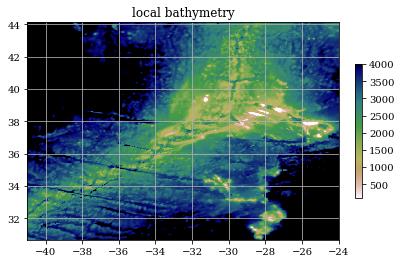

In [13]:
# plot topo
plt.figure()
plt.pcolormesh(lon.mean(axis=0), lat.mean(axis=1), topo, cmap="gist_earth_r", vmin=100, vmax=4000)
plt.colorbar(fraction=.02)
plt.grid(True)
plt.title('local bathymetry')
if dosavefig:
    plt.savefig(picdir+"{0}_topo_{1:04d}-{2:04d}_{3:04d}-{4:04d}.png".format(simul\
                        ,j1,j2,i1,i2), magnification="auto", bbox_inches="tight", dpi=200)
    
ds_cell = 1./pm/pn
#z_r = zlev.zlev_rho(topo, np.zeros((Ny,Nx)), hc, Cs_r)
#dzw = zlev.dz_anyND(topo.T,np.zeros((Nx,Ny)),hc,np.diff(Cs_w),Nz).T

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


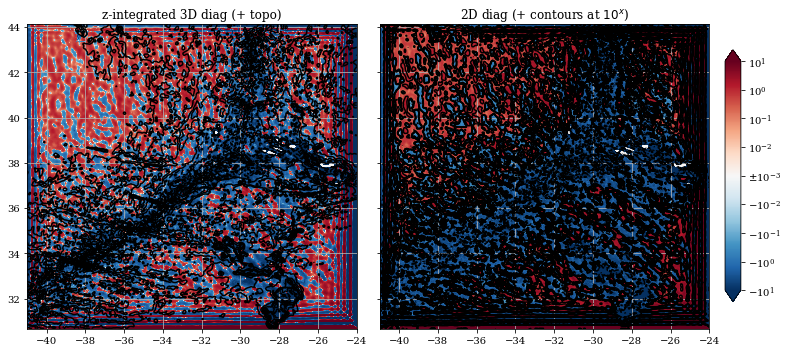

In [14]:
# plot z-int 3D field and 2D diag, horizontal maps (checking consistency)

diss_int = diss.sum(axis=0)

cmap = "RdBu_r"
amp = 10
logthresh = -3
logmax = 1
norm = mpl.colors.SymLogNorm(linthresh=10**logthresh, vmin=-10**logmax, vmax=10**logmax, linscale=0)
levels = np.logspace(logthresh, logmax, logmax-logthresh+1)
levels = np.r_[-levels[:0:-1], 0, levels[1:]]

fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(11,5))
hct = axs[0].pcolormesh(lon.mean(axis=0), lat.mean(axis=1), diss_int, cmap=cmap, norm=norm)
hct = axs[1].pcolormesh(lon.mean(axis=0), lat.mean(axis=1), vmix+hdif, cmap=cmap, norm=norm)

axs[0].set_title('z-integrated 3D diag (+ topo)')
axs[1].set_title(r'2D diag (+ contours at $10^x$)')

for ax in axs:
    ax.grid(True)   
fig.tight_layout()

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
ac = fig.colorbar(hct, cax=cbar_ax, extend="both", ticks=levels)
ticklabs = ac.ax.get_yticklabels()
ticklabs[len(ticklabs)//2] = r'$\pm\mathdefault{10^{-3}}$'
ac.set_ticklabels(ticklabs)

# add contour levels of bathymetry (left panel)
href = 2000
axs[0].contour(lon.mean(axis=0), lat.mean(axis=1), topo-href, colors="k", levels=np.arange(-2000,2001,500))
# add contour levels of log(dissip) (right panel)
alog = -3
levc = np.r_[np.arange(-logmax+alog,-1), 0, np.arange(1,logmax-alog)]
axs[1].contour(lon.mean(axis=0), lat.mean(axis=1), symlog(diss_int,alog), levels=levc, colors="k")

if dosavefig:
    plt.savefig(picdir+"{0}_KEdiss-map_{1:04d}-{2:04d}_{3:04d}-{4:04d}.png".format(simul\
                        ,j1,j2,i1,i2), magnification="auto", bbox_inches="tight", dpi=200)

In [ ]:
hct = axs[1].pcolormesh(lon.mean(axis=0), lat.mean(axis=1), vmix+hdif, cmap=cmap, norm=norm)

/home/lahaye/Coding/virtual_envs/py3-jhub/lib/python3.5/site-packages/matplotlib/figure.py:1999: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


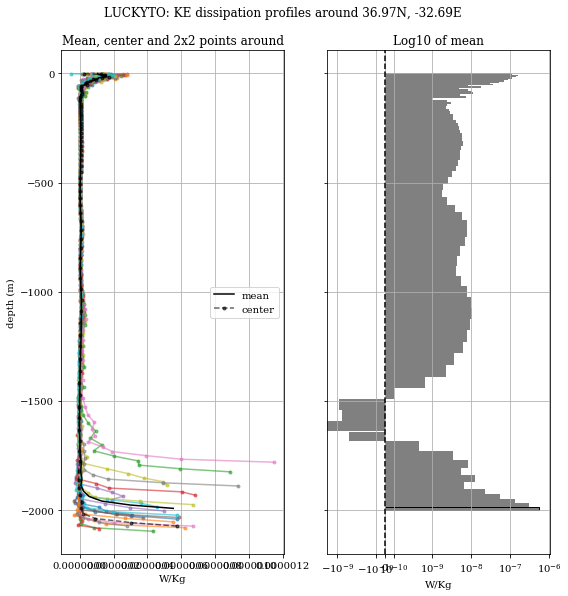

In [9]:
# visualize vertical profiles at a few horizontal points

j0, i0, siz = 100, 100, 2
jy, ix = slice(j0-siz,j0+siz+1,1), slice(i0-siz,i0+siz,1)

zz = zlev.zlev_rho(topo[jy,ix].ravel(), np.zeros(topo[jy,ix].ravel().shape) \
                   , hc, Cs_r).squeeze().T
dz = zlev.dz_anyND(topo[jy,ix].ravel(), np.zeros(topo[jy,ix].ravel().shape) \
                      , hc, np.diff(Cs_w), Nz).squeeze().T
dv_cell = dz*ds_cell[jy,ix].ravel()[None,:]
diss_mean = (diss[:,jy,ix].reshape(Nz,-1)/dv_cell).mean(axis=1)

fig, axs = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(8,8))

ax = axs[0]
ax.plot(-diss[:,jy,ix].reshape(Nz,-1)/dv_cell, zz, '.-', alpha=.6)
ax.plot(-diss_mean, zz.mean(axis=1), "k", label="mean")
ax.plot(-diss[:,j0,i0]/dv_cell[:,siz**2+siz-1], zz[:,siz**2+siz], ".--k" \
                                                , alpha=.6, label="center")
ax.legend(loc="center right")
ax.set_title("Mean, center and {0}x{0} points around".format(siz))
ax.set_ylabel('depth (m)')

ax = axs[1]
ax.barh(zz.mean(axis=1), -diss_mean, dz.mean(axis=1), facecolor="grey", edgecolor="k")
ax.set_xscale("symlog", linthreshx=1e-10, linscalex=.2)
ax.axvline(0, color="k", lw=1.5, linestyle="--")
ax.set_title('Log10 of mean')
for ax in axs:
    ax.grid(True)
    ax.set_xlabel('W/Kg')

fig.set_tight_layout(True)
fig.suptitle(simul.upper()+": KE dissipation profiles around {0:.2f}N, {1:.2f}E "\
                             .format(lat[j0,i0],lon[j0,i0]), y=1.03)

if dosavefig:
    plt.savefig(picdir+"{0}_KEdiss-prof_j{1:04d}_i{2:04d}.pdf".format(simul\
                        ,j0,i0), magnification="auto", bbox_inches="tight", dpi=200)

In [5]:
# AKv, from mean file
nc = Dataset(path_mean, "r")
AKv = nc.variables['AKv'][0,:,j1:j2:nsx,:][:,:,i1:i2:nsx]
nc.close()

zw = zlev.zlev_w(topo.T, np.zeros(topo.T.shape) \
                   , hc, Cs_w).T
AKint = np.trapz(AKv, zw, axis=0)

Text(0.5,1,'LUCKYTO: Time-averaged z-integrated AKv')

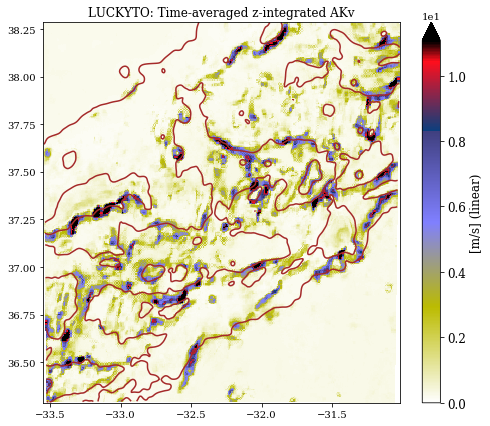

In [6]:
mysc = "linear"

if mysc == "log":
    toplot = np.log10(AKint)
    vmax = np.nanmax(toplot)
    vmin = vmax - 2
else:
    toplot = AKint
    vmin, vmax = 0, np.nanmean(toplot) + 5*np.nanstd(toplot)


zlevs = [1000, 2000, 3500]

cmap = "gist_stern_r"
topocol = "brown"
fs = 12

fig = plt.figure(figsize=(8,7))
ax = plt.gca()

hct = ax.contour(lon, lat, topo, levels=zlevs, colors=topocol)
for item in hct.collections:
    item.set_rasterized(True)

hpc = ax.pcolormesh(lon, lat, toplot, vmin=vmin, vmax=vmax, cmap=cmap)

hcb = plt.colorbar(hpc, ax=ax, extend="max")
hcb.formatter.set_powerlimits((-1, 1))
hcb.update_ticks()
hcb.ax.tick_params(labelsize=fs)
hcb.set_label(r'[m/s] ({})'.format(mysc), fontsize=fs)


#hct = ax.contour(xx, yy, rad, levels=np.array(rlevs)*1.852, colors="tab:green", linestyles="--", linewidths=2)
#cls = ax.clabel(hct)
#for ii,cl in enumerate(cls):
#    cl.set_text(str(round(rlevs[ii])))

plt.title("{}: Time-averaged z-integrated AKv".format(simul.upper()))

#plt.savefig("pictures/MomarPrep/{0}_AKv-zint_{1}.png".format(simul,mysc) \
#            , magnification="auto", bbox_inches="tight", dpi=150)

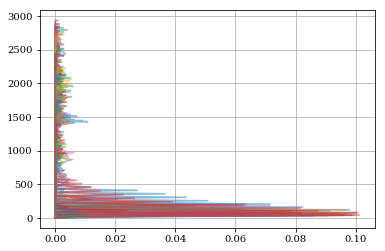

In [14]:
ii, jj = slice(10,290,20), slice(10,290,20)
plt.plot(AKv[:,jj,ii].reshape(81,-1), (zw[:,jj,ii]-zw[0,jj,ii]).reshape(81,-1), alpha=.5)
plt.grid(True)

In [7]:
zw.shape, AKv.shape

((81, 296, 296), (81, 296, 296))